In this example we will fit V921 Sco data from VLT/VISIR instrument
Firstly, we define functions which we need for custom radial profile fitter (you will need to import them from custom_photometry.py file)
Science object need to be in center of image and pixels values must be in Jy

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.visualization import ImageNormalize, ZScaleInterval, PercentileInterval
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u
from astropy.coordinates import SkyCoord

from photutils import SkyCircularAperture
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from astropy.stats import sigma_clipped_stats

def photometry_custom(image_data, radpix, wcs):
    #aperture = CircularAperture((image_data.shape[0]/2,image_data.shape[0]/2), radpix[19])
    position = [image_data.shape[0]/2,image_data.shape[0]/2]
    apertures = [CircularAperture(position, r=r) for r in radpix]
    annulus_aperture = CircularAnnulus(position, r_in=radpix[19], r_out=radpix[19]+radpix[16])
    phot_table = aperture_photometry(image_data, apertures, wcs=wcs)
    
    annulus_masks = annulus_aperture.to_mask(method='center')
    annulus_data = annulus_masks.multiply(image_data)
    mask = annulus_masks.data
    annulus_data_1d = annulus_data[mask > 0]
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_mean = median_sigclip
    
    #sky_aperture = to_sky(apertures,wcs)
    phot_array = np.zeros(20)
    bkg_sum_array = np.zeros(20)
    for i in range(0,20):
        phot_array[i] = phot_table['aperture_sum_' + str(i)][0]
        bkg_sum_array[i] = bkg_mean * apertures[i].area
    
    final_sum =  phot_array - bkg_sum_array  
    
    scale = np.mean(proj_plane_pixel_scales(wcs))    
    phot_Jy_custom = final_sum
    
    print('Backgorud outer radius =',radpix[19]+radpix[16],'pixels')
    print(phot_table)
    return(phot_Jy_custom )

Next, we will define main tools fucntions which needed for operate fits file and chi2 fitting 

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def rob_fits(user_fitsfile):
    hdul = fits.open(user_fitsfile)
    wavelength = hdul['SPECTRAL_INFO'].data
    wave = wavelength['WAVELENGTH']
    aperture = hdul['APERTURES'].data
    ap = aperture['APERTURE']  
    fnu = hdul['VALUES'].data
    mod_names = hdul['MODEL_NAMES'].data
    names = np.array(mod_names.astype('<U11'))
    return(ap, wave, fnu*(1000/dist)**2/1000, names)

def user_fits(rob_fitsfile,ap,flag):
    hdul = fits.open(rob_fitsfile)
    hdul.info()
    image_data = hdul[0].data[::-1,: ] #инвертирует ось y
    wcs = WCS(hdul[0].header)
    waveleng = 18.7422 #hdul[0].header['WAVELENG']
    scale = np.mean(proj_plane_pixel_scales(wcs))*3600
    #scale = np.abs(CDELT1)*3600  #arcsec/pix
    FOV = image_data.shape[0]*scale
    hdul.close()
    print("Scale =",scale, " arcsec/pix")
    print("FOV=", FOV/60/60, "deg")
    print('Image data shape:', image_data.shape)
    # AU           | 1.49598e+11 m 
    # pc           | 3.08568e+16 m  
    L = dist * FOV    #мой способ!!
    aupixel = L/image_data.shape[0]   # AU in pixel
    radius = ap/aupixel/2

    radpix = ap/2/dist/scale
    print('MAX RADIUS =', radpix[19], 'pix')
    
    #norm = ImageNormalize(image_data, interval=ZScaleInterval())         # Scale = ZScale
    norm = ImageNormalize(image_data, interval=PercentileInterval(99.5))  # Scale = 99.5%

    #ax = plt.subplot(projection=wcs)
    #for i in range(0,len(radpix)):
    #    ax.add_patch(plt.Circle((image_data.shape[0]/2,image_data.shape[0]/2), radpix[i] ,lw = 0.1, color='r', fill=False))
    #    ax.add_patch(plt.Circle((image_data.shape[0]/2,image_data.shape[0]/2), radpix[19]+ radpix[16] ,lw = 0.5, color='green', fill=False))
    #plt.imshow(image_data, cmap='gray',  norm=norm)
    #plt.xlabel('Galactic Longitude')
    #plt.ylabel('Galactic Latitude')
    #plt.colorbar()
    #plt.savefig(str(obj_name +'_' + models +'_' + flag +'.png') , dpi=300)
    print('Min:', np.min(image_data))
    print('Max:', np.max(image_data))
    print('Mean:', np.mean(image_data))
    print('Stdev:', np.std(image_data))
    return(image_data, radpix, wcs, scale, waveleng,  aupixel )

def chi2_func(phot_Jy, fnu, wave_index, models,names,flag):
    chi2 = np.zeros(fnu.shape[0])
    for i in range(0,fnu.shape[0]):
        #chi2[i] = ((phot_Jy_MSX_A - fnu[i,:,wave_index])**2 *radpix**2).sum()
        chi2[i] = ((phot_Jy - fnu[i,:,wave_index])**2).sum()
        #idx = [chi2 == min(chi2)]
    #index = np.where(idx)[1]
    index = np.where(chi2 == np.nanmin(chi2))[0]
    #print('chi2 min =',np.nanmin(chi2))
    #print(index)
    plt.figure()
    plt.plot(ap , phot_Jy, 'r.', label="Observable data") 
    plt.plot(ap , fnu[int(index) ,:,wave_index], 'b+', label="Model data")
    plt.legend(bbox_to_anchor=(1, 0.6))
    plt.xlabel('AU')
    plt.ylabel('Jy')
    plt.title('%s  %s \n $\chi^2$ = %f %s \n VISIR_%s'%(obj_name, models, chi2[index], names[index],flag))
    plt.savefig(str('fit_'+ obj_name +'_' + models +'.png') , dpi=300)
    plt.show()
    return(chi2, wave_index)

Below we will define object name, distance and which models we want to use. Alse need to define where is custom fits files.

In [3]:
obj_name = 'V921 Sco'
dist = 1650 #pc
arr= ['spubhmi']
#arr=['s-pbhmi','s-pbsmi','sp--h-i','s-p-hmi','sp--hmi','sp--s-i','s-p-smi','sp--smi',
#    'spu-hmi','spu-smi','s---s-i','s---smi','s-ubhmi','s-ubsmi','s-u-hmi','s-u-smi']
arr_userfile=['/home/buddy/Documents/MIPT/VISIR/V921Sco/V921Sco_median_Jy.fits']

Here presented code to use tools to fit custom data.

Filename: /home/buddy/Documents/MIPT/VISIR/V921Sco/V921Sco_median_Jy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     826   (256, 256)   float64   
Scale = 0.127000000008  arcsec/pix
FOV= 0.00903111111168 deg
Image data shape: (256, 256)
MAX RADIUS = 2386.065378041059 pix
Min: -1.9624105322266452
Max: 148.1897689371729
Mean: 0.31293542714377065
Stdev: 1.8900634920506274


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Backgorud outer radius = 2943.383791055373 pixels
 id xcenter ycenter ...  aperture_sum_17   aperture_sum_18    aperture_sum_19  
      pix     pix   ...                                                        
--- ------- ------- ... ----------------- ------------------ ------------------
  1   128.0   128.0 ... 205.0853615329416 205.08536153294153 205.08536153294165
User waveleng = 18.7422 um
Models waveleng = 18.308818377145872 um /index = 85


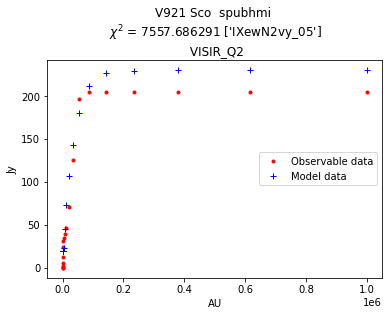

final_chi2 min = 7557.68629129948
[322780]


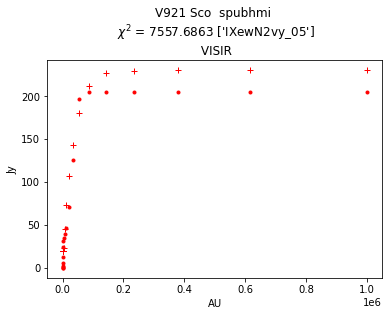

In [4]:
for models in arr:
    rob_fitsfile = '/home/buddy/Documents/MIPT/Hyperion/%s/flux.fits'%(models)
    ap, wave, fnu, names = rob_fits(rob_fitsfile)
   
    image_data, radpix, wcs, scale, waveleng, aupixel  = user_fits(arr_userfile[0], ap, flag='Q2')
    image_data = np.nan_to_num(image_data, nan=0.0)
    phot_Jy = photometry_custom(image_data, radpix, wcs)
    rob_wave, wave_index = find_nearest(wave, waveleng)
    print('User waveleng =', waveleng, 'um')
    print('Models waveleng =', rob_wave, 'um', '/index =',wave_index)
    chi2, wave1_index = chi2_func(phot_Jy, fnu, wave_index, models, names, flag ='Q2')
    
    
    final_chi2 = chi2
    index = np.where(final_chi2 == np.nanmin(final_chi2))[0]
    
    print('final_chi2 min =',np.nanmin(final_chi2))
    print(index)
    plt.figure()
    plt.plot(ap , phot_Jy, 'r.') 
    plt.plot(ap , fnu[int(index) ,:,wave1_index], 'r+')
    plt.xlabel('AU')
    plt.ylabel('Jy')
    plt.title('%s  %s \n $\chi^2$ = %0.4f %s \n VISIR'%(obj_name, models, final_chi2[index], names[index]))
    plt.savefig(str('fit_'+ obj_name +'_'+'ACDE'+'_' + models +'.png') , dpi=300)
    plt.show()